In [37]:
library(data.table)
library(glmnet)
library(ggplot2)
library(lubridate, quietly=TRUE)
library(zoo, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(GGally, quietly=TRUE)
library(caTools)
library(rpart)
library(rattle)
library(caret)
library(e1071)
library(randomForest)
library(gbm)
library(fastDummies)

### Performance Function

In [6]:
perf_dt=function(type,actual,forecast){
    name=type
    n=length(actual)
    error=actual-forecast
    mean=mean(actual)
    sd=sd(actual)
    FBias=sum(error)/sum(actual)
    MPE=sum(error/actual)/n
    MAPE=sum(abs(error/actual))/n
    RMSE=sqrt(sum(error^2))/n
    MAD=sum(abs(error))/n
    WMAPE=MAD/mean
    l=data.frame(name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE)
    return(l)
}

# Student Performance Dataset

Attribute Information:

instr: Instructor's identifier; values taken from {1,2,3}

class: Course code (descriptor); values taken from {1-13}

repeat: Number of times the student is taking this course; values taken from {0,1,2,3,...}

attendance: Code of the level of attendance; values from {0, 1, 2, 3, 4}

difficulty: Level of difficulty of the course as perceived by the student; values taken from {1,2,3,4,5}

Q1: The semester course content, teaching method and evaluation system were provided at the start.

Q2: The course aims and objectives were clearly stated at the beginning of the period.

Q3: The course was worth the amount of credit assigned to it.

Q4: The course was taught according to the syllabus announced on the first day of class.

Q5: The class discussions, homework assignments, applications and studies were satisfactory.

Q6: The textbook and other courses resources were sufficient and up to date.

Q7: The course allowed field work, applications, laboratory, discussion and other studies.

Q8: The quizzes, assignments, projects and exams contributed to helping the learning.

Q9: I greatly enjoyed the class and was eager to actively participate during the lectures.

Q10: My initial expectations about the course were met at the end of the period or year.

Q11: The course was relevant and beneficial to my professional development.

Q12: The course helped me look at life and the world with a new perspective.

Q13: The Instructor's knowledge was relevant and up to date.

Q14: The Instructor came prepared for classes.

Q15: The Instructor taught in accordance with the announced lesson plan.

Q16: The Instructor was committed to the course and was understandable.

Q17: The Instructor arrived on time for classes.

Q18: The Instructor has a smooth and easy to follow delivery/speech.

Q19: The Instructor made effective use of class hours.

Q20: The Instructor explained the course and was eager to be helpful to students.

Q21: The Instructor demonstrated a positive approach to students.

Q22: The Instructor was open and respectful of the views of students about the course.

Q23: The Instructor encouraged participation in the course.

Q24: The Instructor gave relevant homework assignments/projects, and helped/guided students.

Q25: The Instructor responded to questions about the course inside and outside of the course.

Q26: The Instructor's evaluation system (midterm and final questions, projects, assignments, etc.) effectively measured the course objectives.

Q27: The Instructor provided solutions to exams and discussed them with students.

Q28: The Instructor treated all students in a right and objective manner.

Q1-Q28 are all Likert-type, meaning that the values are taken from {1,2,3,4,5}

### Loading Dataset

In [7]:
std_eva=read.csv("turkiye-student-evaluation_R_Specific.csv")
std_eva=as.data.table(std_eva)

In [8]:
for (i in colnames(std_eva)){
   std_eva[[i]]=as.factor(std_eva[[i]])
}

In [9]:
std_eva[,y:=difficulty]
std_eva[,difficulty:=NULL]

Warning message in `[.data.table`(std_eva, , `:=`(y, difficulty)):
"Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved."

In [10]:
str(std_eva)

Classes 'data.table' and 'data.frame':	5820 obs. of  33 variables:
 $ instr     : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ class     : Factor w/ 13 levels "1","2","3","4",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ nb.repeat : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ attendance: Factor w/ 5 levels "0","1","2","3",..: 1 2 3 2 1 4 2 2 2 5 ...
 $ Q1        : Factor w/ 5 levels "1","2","3","4",..: 3 3 5 3 1 4 4 5 4 4 ...
 $ Q2        : Factor w/ 5 levels "1","2","3","4",..: 3 3 5 3 1 4 4 5 4 4 ...
 $ Q3        : Factor w/ 5 levels "1","2","3","4",..: 3 3 5 3 1 4 4 5 4 4 ...
 $ Q4        : Factor w/ 5 levels "1","2","3","4",..: 3 3 5 3 1 4 4 5 4 4 ...
 $ Q5        : Factor w/ 5 levels "1","2","3","4",..: 3 3 5 3 1 4 4 5 4 4 ...
 $ Q6        : Factor w/ 5 levels "1","2","3","4",..: 3 3 5 3 1 4 4 5 4 4 ...
 $ Q7        : Factor w/ 5 levels "1","2","3","4",..: 3 3 5 3 1 4 4 5 4 4 ...
 $ Q8        : Factor w/ 5 levels "1","2","3","4",..: 3 3 5 3 1 4 4 5 4 4 ...
 $ Q9     

In [11]:
set.seed(35)
spl=sample.split(std_eva$y, SplitRatio = 0.8)
train=subset(std_eva,spl==TRUE)
test=subset(std_eva,spl==FALSE)

## Penalized Regression Approaches(PRA)

### L1 Penalty with Mean Square Error measure

In order to tune lambda values, glmnet packages are used to get best lambda values for Penalized Regression. 

In [20]:
train_mat=data.matrix(train[complete.cases(train),-c("y"),with=F])

result_vec=as.vector(t(train[complete.cases(train),"y"]))

cvfit=cv.glmnet(train_mat,result_vec,family="multinomial",nfolds = 10, type.measure="mse")

test_mat=data.matrix(test[complete.cases(test),-c("y")])

lasso_model_mse_min <- glmnet(train_mat,result_vec, alpha = 1, lambda = cvfit$lambda.min, standardize = FALSE,family="multinomial")
lasso_model_mse_1se <- glmnet(train_mat,result_vec, alpha = 1, lambda = cvfit$lambda.1se, standardize = FALSE,family="multinomial")
lasso_model_mse_10th <- glmnet(train_mat,result_vec, alpha = 1, lambda = cvfit$lambda[10], standardize = FALSE,family="multinomial")

In [14]:
# train_mat=data.matrix(train[complete.cases(train),-c("y"),with=F])

# result_vec=as.vector(t(train[complete.cases(train),"y"]))

# cvfit=cv.glmnet(train_mat,result_vec,family="multinomial",nfolds = 10)

# test_mat=data.matrix(test[complete.cases(test),-c("y")])

# lasso_model <- glmnet(train_mat,result_vec, alpha = 1, lambda = cvfit$lambda.min, standardize = FALSE,family="multinomial")

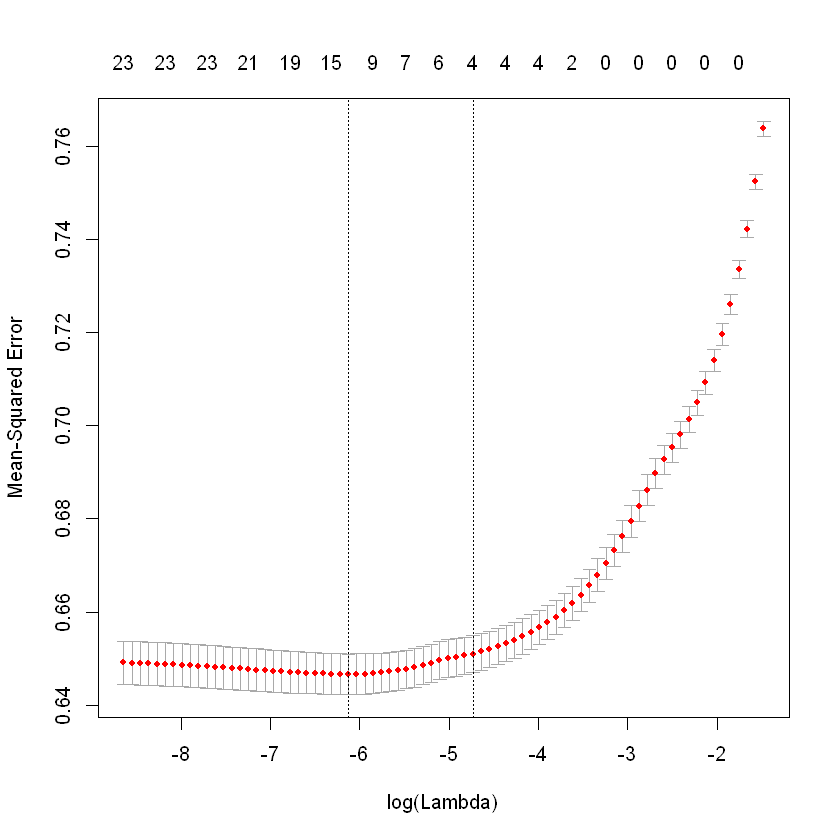

In [16]:
plot(cvfit)

### Lambda Values for Mean Square Error Values

In [17]:
cvfit$lambda.min

[1] 0.002179314

In [18]:
cvfit$lambda.1se

[1] 0.008797927

In [19]:
cvfit$lambda[10]

[1] 0.09882922

2 possible lambda values are determined by the cv.glmnet(). One of them is used for getting minimum Mean-Squared Error. The other one is determined by looking how many paramater is used in the model. Namely, this lambda value can be beneficial for reducing the possibility of over-fitting model on train dataset. Lastly, one random lambda was selected to compare results for these 3 lambda values.

In [23]:
prediction_pra_mse_min <- predict(lasso_model_mse_min, s = cvfit$lambda.min, newx = test_mat, type="class")
prediction_pra_mse_1se <- predict(lasso_model_mse_1se, s = cvfit$lambda.1se, newx = test_mat, type="class")
prediction_pra_mse_10th <- predict(lasso_model_mse_10th, s = cvfit$lambda[10], newx = test_mat, type="class")

## L1 Penalty with Mean Absolute Error measure

In [25]:
train_mat=data.matrix(train[complete.cases(train),-c("y"),with=F])

result_vec=as.vector(t(train[complete.cases(train),"y"]))

cvfit_mae=cv.glmnet(train_mat,result_vec,family="multinomial",nfolds = 10, type.measure="mae")

test_mat=data.matrix(test[complete.cases(test),-c("y")])

lasso_model_mae_min <- glmnet(train_mat,result_vec, alpha = 1, lambda = cvfit_mae$lambda.min, standardize = FALSE,family="multinomial")
lasso_model_mae_1se <- glmnet(train_mat,result_vec, alpha = 1, lambda = cvfit_mae$lambda.1se, standardize = FALSE,family="multinomial")
lasso_model_mae_10th <- glmnet(train_mat,result_vec, alpha = 1, lambda = cvfit_mae$lambda[10], standardize = FALSE,family="multinomial")

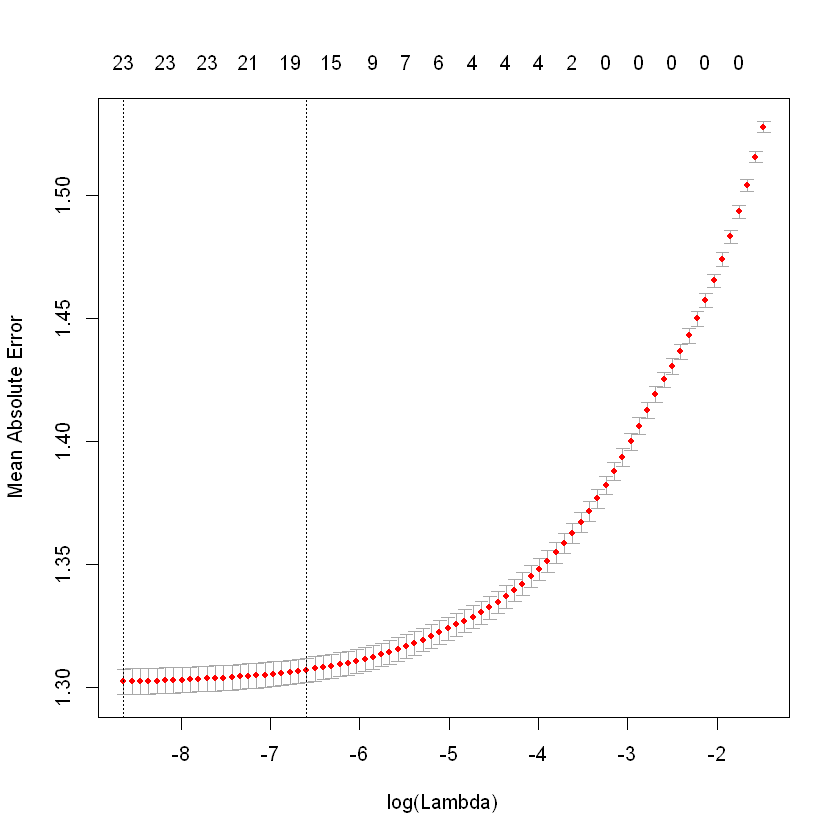

In [27]:
plot(cvfit_mae)

### Lambda Values for Mean Square Error Values

In [28]:
cvfit_mae$lambda.min

[1] 0.0001767708

In [29]:
cvfit_mae$lambda.1se

[1] 0.001368672

In [30]:
cvfit_mae$lambda[10]

[1] 0.09882922

2 possible lambda values are determined by the cv.glmnet(). One of them is used for getting minimum Mean-Squared Error. The other one is determined by looking how many paramater is used in the model. Namely, this lambda value can be beneficial for reducing the possibility of over-fitting model on train dataset. Lastly, one random lambda was selected to compare results for these 3 lambda values.

In [31]:
prediction_pra_mae_min <- predict(lasso_model_mae_min, s = cvfit_mae$lambda.min, newx = test_mat, type="class")
prediction_pra_mae_1se <- predict(lasso_model_mae_1se, s = cvfit_mae$lambda.1se, newx = test_mat, type="class")
prediction_pra_mae_10th <- predict(lasso_model_mae_10th, s = cvfit_mae$lambda[10], newx = test_mat, type="class")

### Performance Measure for Lasso Regression

In [33]:
perf_dt("Student Data Set for Lasso Function with min lambda and mse objective", as.numeric(test$y), as.numeric(prediction_pra_mse_min))
perf_dt("Student Data Set for Lasso Function with 1se lambda and mse objective", as.numeric(test$y), as.numeric(prediction_pra_mse_1se))
perf_dt("Student Data Set for Lasso Function with 10th lambda and mse objective", as.numeric(test$y), as.numeric(prediction_pra_mse_10th))

perf_dt("Student Data Set for Lasso Function with min lambda and mae objective", as.numeric(test$y), as.numeric(prediction_pra_mae_min))
perf_dt("Student Data Set for Lasso Function with 1se lambda and mae objective", as.numeric(test$y), as.numeric(prediction_pra_mae_1se))
perf_dt("Student Data Set for Lasso Function with 10th lambda and mae objective", as.numeric(test$y), as.numeric(prediction_pra_mae_10th))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Student Data Set for Lasso Function with min lambda and mse objective,1164,2.782646,1.348866,0.1358444,0.3637743,0.04162901,0.919244,0.3303489


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Student Data Set for Lasso Function with 1se lambda and mse objective,1164,2.782646,1.348866,0.1917258,0.3418528,0.04153138,0.9235395,0.3318926


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Student Data Set for Lasso Function with 10th lambda and mse objective,1164,2.782646,1.348866,0.2701451,0.3632732,0.0456783,1.054124,0.3788206


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Student Data Set for Lasso Function with min lambda and mae objective,1164,2.782646,1.348866,0.12226,0.3734107,0.04217504,0.9243986,0.3322013


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Student Data Set for Lasso Function with 1se lambda and mae objective,1164,2.782646,1.348866,0.1287434,0.3700888,0.04177944,0.9252577,0.33251


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Student Data Set for Lasso Function with 10th lambda and mae objective,1164,2.782646,1.348866,0.2701451,0.3632732,0.0456783,1.054124,0.3788206


In [34]:
confusionMatrix(data = as.factor(prediction_pra_mae_min), reference = as.factor(test$y), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4   5
         1 249  28  61  49  37
         2   0   1   0   1   0
         3  56  70 255 155  60
         4   9   8  23  29  14
         5  10   3  16  11  19

Overall Statistics
                                          
               Accuracy : 0.4751          
                 95% CI : (0.4461, 0.5042)
    No Information Rate : 0.305           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2726          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 1  Class: 2 Class: 3 Class: 4 Class: 5
Precision              0.5873 0.5000000   0.4279  0.34940  0.32203
Recall                 0.7685 0.0090909   0.7183  0.11837  0.14615
F1                     0.6658 0.0178571   0.5363  0.17683  0.20106
Prevalence             0.2784 0.0945017   0.3050  0.21048  0.11

## Decision Tree(DT)

In [ ]:
set.seed(35)

In [65]:
train_dt=cbind(train[,"y"],dummy_cols(train[,1:32])[,33:196])
test_dt=cbind(test[,"y"],dummy_cols(test[,1:32])[,33:196])

CART 

4656 samples
 164 predictor
   5 classes: '1', '2', '3', '4', '5' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4191, 4190, 4191, 4190, 4190, 4190, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa    
  0.00  0.5083649  0.3284912
  0.02  0.4935539  0.2805437
  0.04  0.4935539  0.2805437
  0.06  0.4935539  0.2805437
  0.08  0.4935539  0.2805437
  0.10  0.4935539  0.2805437
  0.12  0.4935539  0.2805437
  0.14  0.4935539  0.2805437
  0.16  0.4935539  0.2805437
  0.18  0.4935539  0.2805437
  0.20  0.4935539  0.2805437

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.
CART 

4656 samples
 164 predictor
   5 classes: '1', '2', '3', '4', '5' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4190, 4190, 4190, 4190, 4191, 4192, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa    
  0.00  0.515253

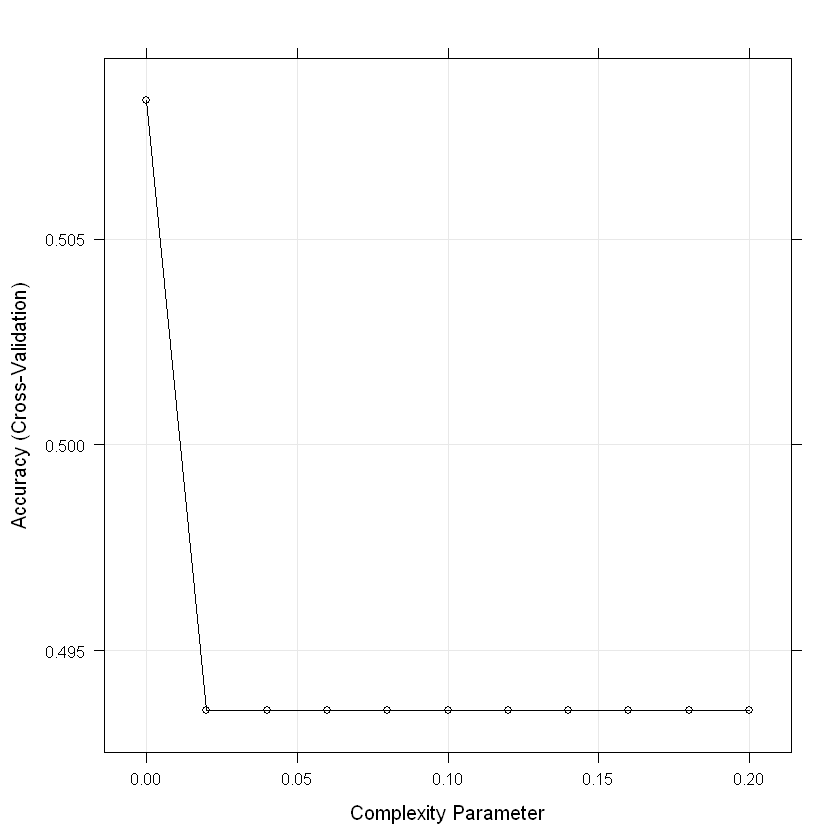

CART 

4656 samples
 164 predictor
   5 classes: '1', '2', '3', '4', '5' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4190, 4190, 4192, 4191, 4190, 4191, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa    
  0.00  0.5133237  0.3338278
  0.02  0.4935599  0.2805675
  0.04  0.4935599  0.2805675
  0.06  0.4935599  0.2805675
  0.08  0.4935599  0.2805675
  0.10  0.4935599  0.2805675
  0.12  0.4935599  0.2805675
  0.14  0.4935599  0.2805675
  0.16  0.4935599  0.2805675
  0.18  0.4935599  0.2805675
  0.20  0.4935599  0.2805675

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.


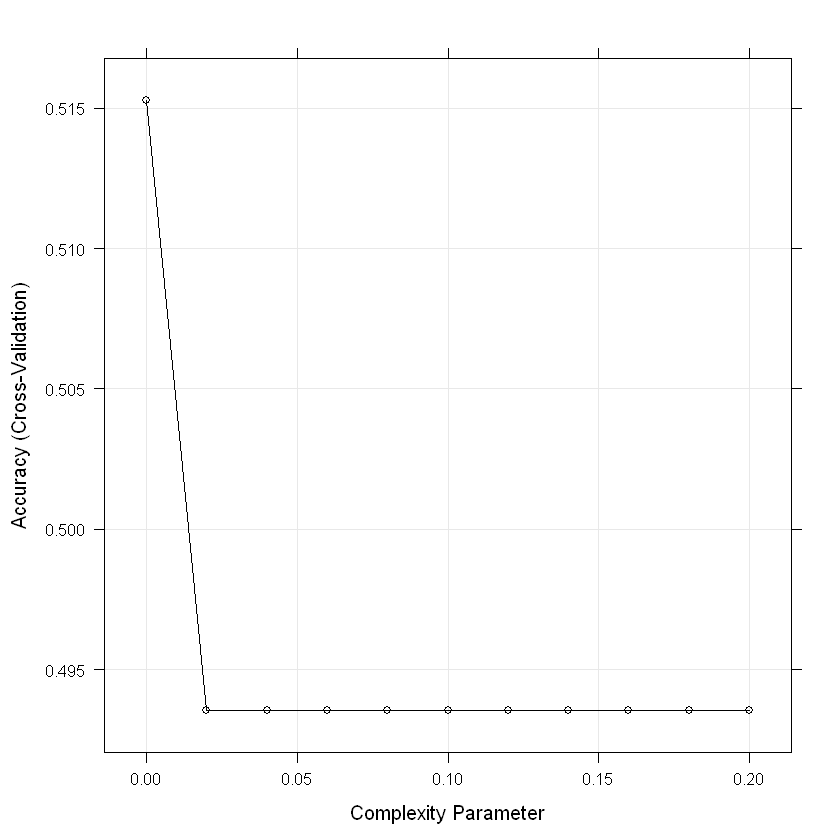

CART 

4656 samples
 164 predictor
   5 classes: '1', '2', '3', '4', '5' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4190, 4190, 4192, 4192, 4189, 4191, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa    
  0.00  0.5066283  0.3267718
  0.02  0.4935368  0.2805211
  0.04  0.4935368  0.2805211
  0.06  0.4935368  0.2805211
  0.08  0.4935368  0.2805211
  0.10  0.4935368  0.2805211
  0.12  0.4935368  0.2805211
  0.14  0.4935368  0.2805211
  0.16  0.4935368  0.2805211
  0.18  0.4935368  0.2805211
  0.20  0.4935368  0.2805211

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.


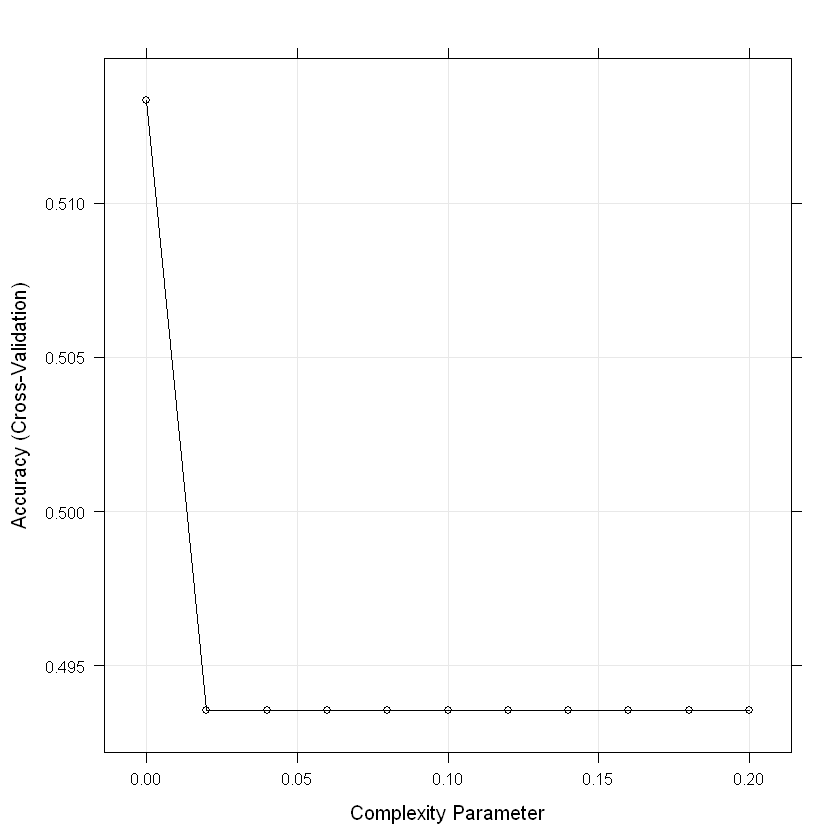

CART 

4656 samples
 164 predictor
   5 classes: '1', '2', '3', '4', '5' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4190, 4190, 4191, 4190, 4190, 4191, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa    
  0.00  0.5103106  0.3260359
  0.02  0.4935613  0.2805745
  0.04  0.4935613  0.2805745
  0.06  0.4935613  0.2805745
  0.08  0.4935613  0.2805745
  0.10  0.4935613  0.2805745
  0.12  0.4935613  0.2805745
  0.14  0.4935613  0.2805745
  0.16  0.4935613  0.2805745
  0.18  0.4935613  0.2805745
  0.20  0.4935613  0.2805745

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.


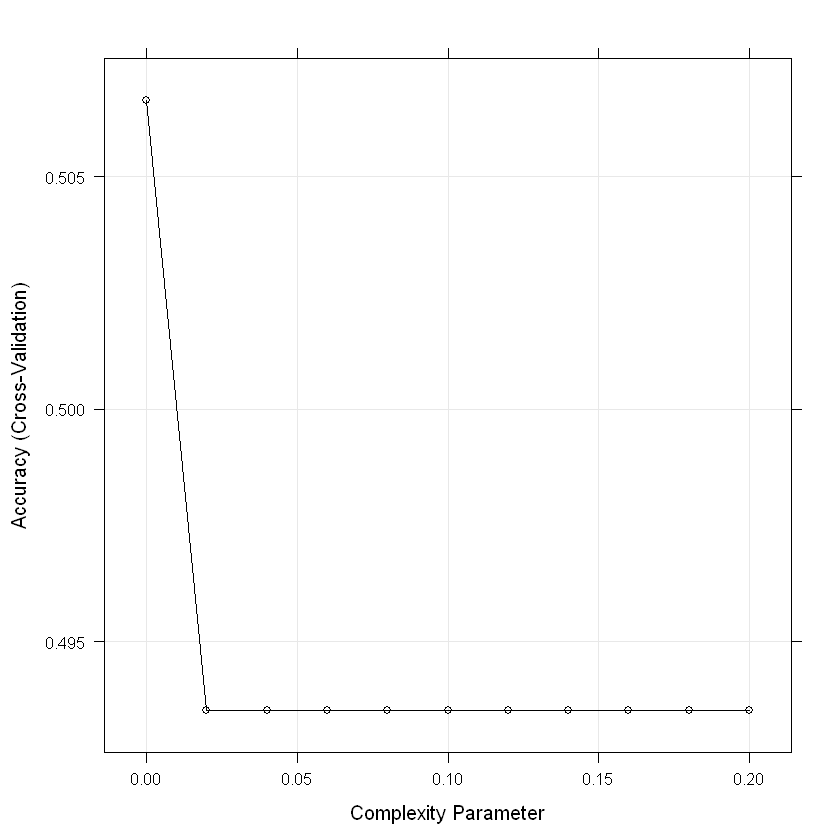

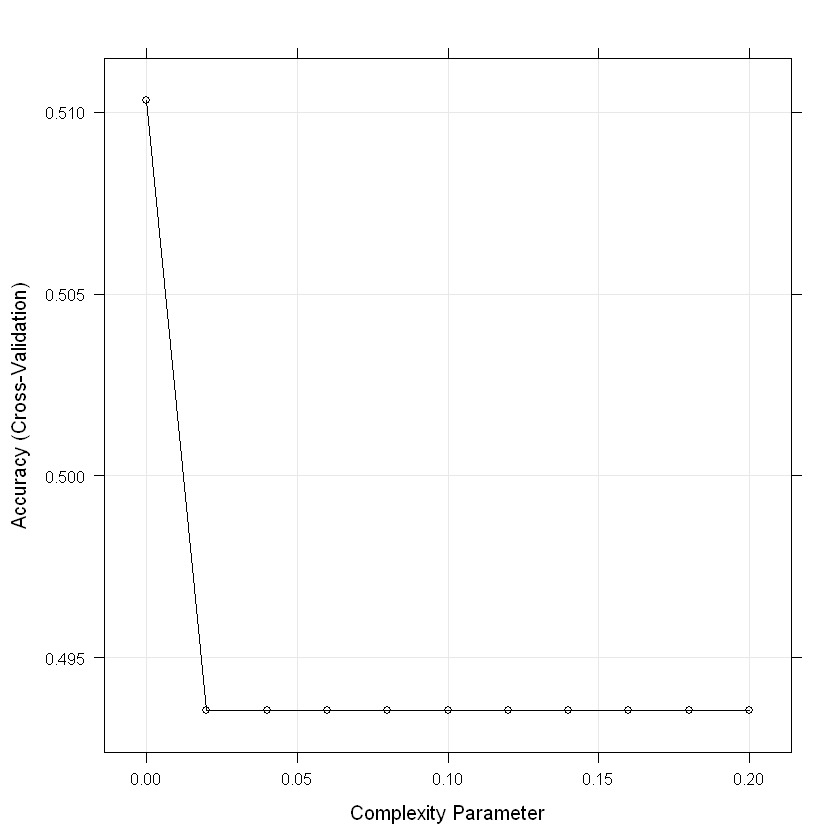

CART 

4656 samples
 164 predictor
   5 classes: '1', '2', '3', '4', '5' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4191, 4191, 4190, 4192, 4190, 4191, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa    
  0.00  0.5085856  0.3261764
  0.02  0.4935627  0.2805648
  0.04  0.4935627  0.2805648
  0.06  0.4935627  0.2805648
  0.08  0.4935627  0.2805648
  0.10  0.4935627  0.2805648
  0.12  0.4935627  0.2805648
  0.14  0.4935627  0.2805648
  0.16  0.4935627  0.2805648
  0.18  0.4935627  0.2805648
  0.20  0.4935627  0.2805648

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.


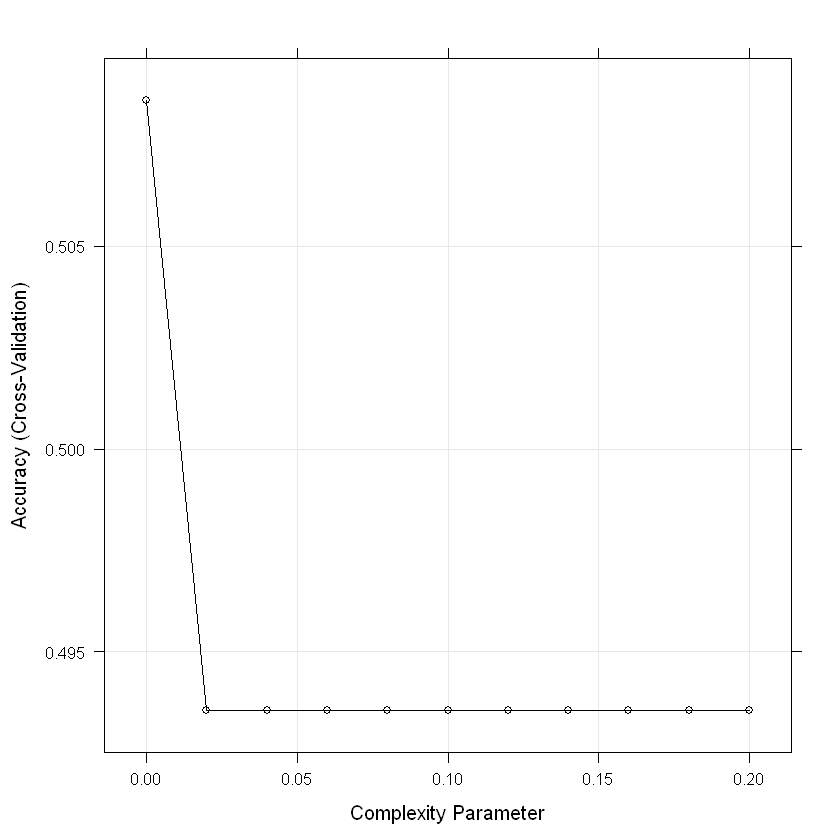

In [74]:
numFolds=trainControl(method="cv",number = 10)
cpGrid=expand.grid(.cp=(0:10)*0.02)
#minbucket_grid=expand.grid(.cp=(5:10))
for(i in 100:105){
    tr=train(y~.,
          data=train_dt, 
          method="rpart",
          trControl=numFolds,
          tuneGrid= cpGrid,
            # minbucket=minbucket_grid
           control= rpart.control(minbucket = i)
            )
    trellis.par.set(caretTheme())
    print(plot(tr))    
    print(tr)
}

CART 

4656 samples
 164 predictor
   5 classes: '1', '2', '3', '4', '5' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4191, 4190, 4190, 4191, 4191, 4189, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa    
  0.00  0.4613438  0.2837636
  0.01  0.4935677  0.2805761
  0.02  0.4935677  0.2805761
  0.03  0.4935677  0.2805761
  0.04  0.4935677  0.2805761
  0.05  0.4935677  0.2805761
  0.06  0.4935677  0.2805761
  0.07  0.4935677  0.2805761
  0.08  0.4935677  0.2805761
  0.09  0.4935677  0.2805761
  0.10  0.4935677  0.2805761

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.1.


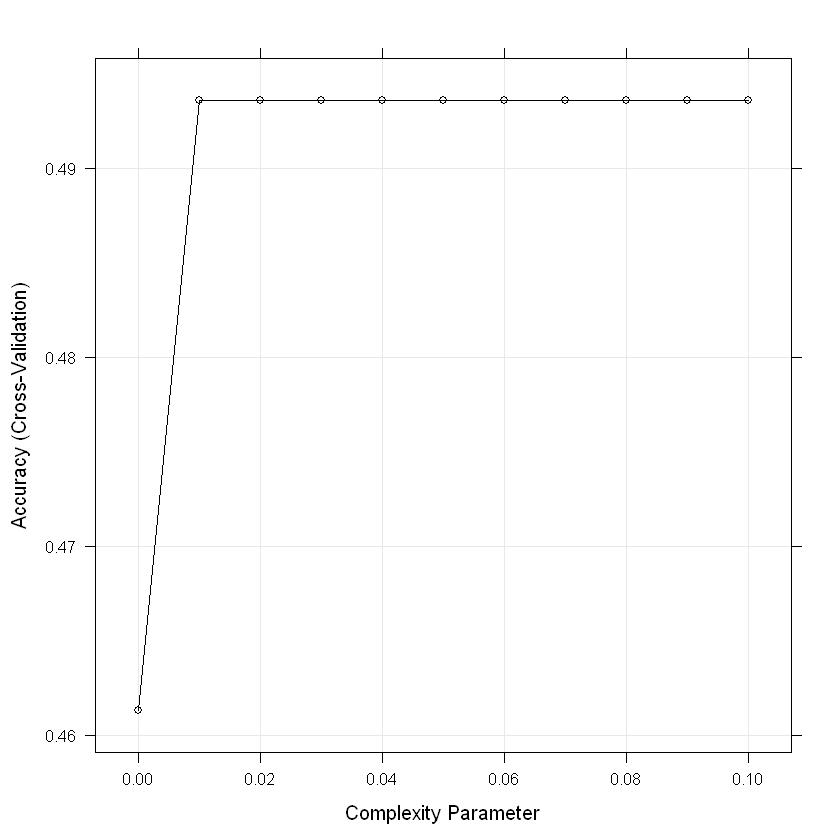

In [75]:
numFolds=trainControl(method="cv",number = 10)
cpGrid=expand.grid(.cp=(0:10)*0.01)
tr=train(y~.,
      data=train_dt, 
      method="rpart",
      trControl=numFolds,
      tuneGrid= cpGrid,
        # minbucket=minbucket_grid
       control= rpart.control(minsplit = 8)
        )
trellis.par.set(caretTheme())
print(plot(tr))    
print(tr)

attendance_0        Q17_1        Q25_1        Q14_1        Q15_1         Q3_1 
   519.07323     31.44874     24.00925     21.30398     20.62767     20.28951

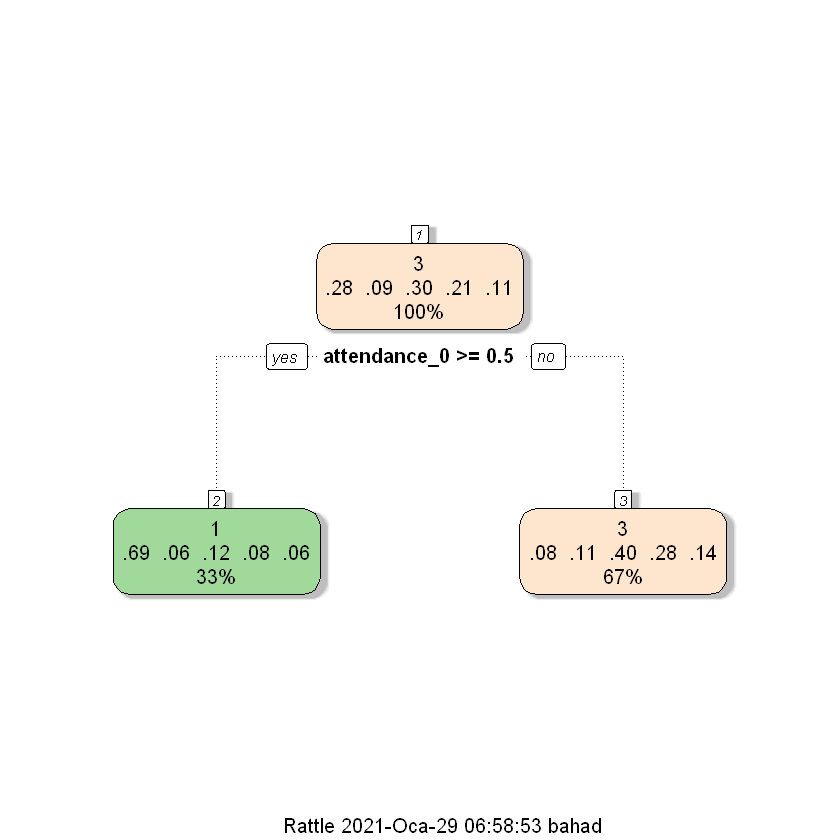

In [76]:
reg_tree_std=tr$finalModel
fancyRpartPlot(reg_tree_std)
reg_tree_std$variable.importance

In [77]:
predicted_std=predict(reg_tree_std,newdata=test_dt,type="class")

In [78]:
table(predicted_std)

predicted_std
  1   2   3   4   5 
367   0 797   0   0 

### Performanca Measure

In [79]:
confusionMatrix(data = as.factor(predicted_std), reference = as.factor(test$y), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4   5
         1 257  14  40  24  32
         2   0   0   0   0   0
         3  67  96 315 221  98
         4   0   0   0   0   0
         5   0   0   0   0   0

Overall Statistics
                                          
               Accuracy : 0.4914          
                 95% CI : (0.4623, 0.5205)
    No Information Rate : 0.305           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.277           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Precision              0.7003       NA   0.3952       NA       NA
Recall                 0.7932   0.0000   0.8873   0.0000   0.0000
F1                     0.7438       NA   0.5469       NA       NA
Prevalence             0.2784   0.0945   0.3050   0.2105   0.1117
D

In [80]:
perf_dt("First Data Set for Decision Tree", as.numeric(predicted_std), as.numeric(test$y))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Decision Tree,1164,2.369416,0.9296636,-0.1744017,0.437858,0.03724006,0.8084192,0.3411893


## Random Forest(RF)

In [82]:
library(ranger)

In [83]:
fitControl=trainControl(method = "repeatedcv",
                           number = 10) 

In [87]:
rf_grid=expand.grid(mtry=c(4,8,10,15),
                   splitrule = c("extratrees"),
                   min.node.size= c(5))
rf_grid  

mtry,splitrule,min.node.size
4,extratrees,5
8,extratrees,5
10,extratrees,5
15,extratrees,5


In [88]:
rf_fit=train(y ~ ., data = train, 
                 method = "ranger", 
                 trControl = fitControl, num.trees=500,
                 tuneGrid = rf_grid) 

Random Forest 

4656 samples
  32 predictor
   5 classes: '1', '2', '3', '4', '5' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 4191, 4190, 4190, 4192, 4189, 4191, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   4    0.4364146  0.2091454
   8    0.4791642  0.2812263
  10    0.4894743  0.2985529
  15    0.4969892  0.3130386

Tuning parameter 'splitrule' was held constant at a value of extratrees

Tuning parameter 'min.node.size' was held constant at a value of 5
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 15, splitrule = extratrees
 and min.node.size = 5.

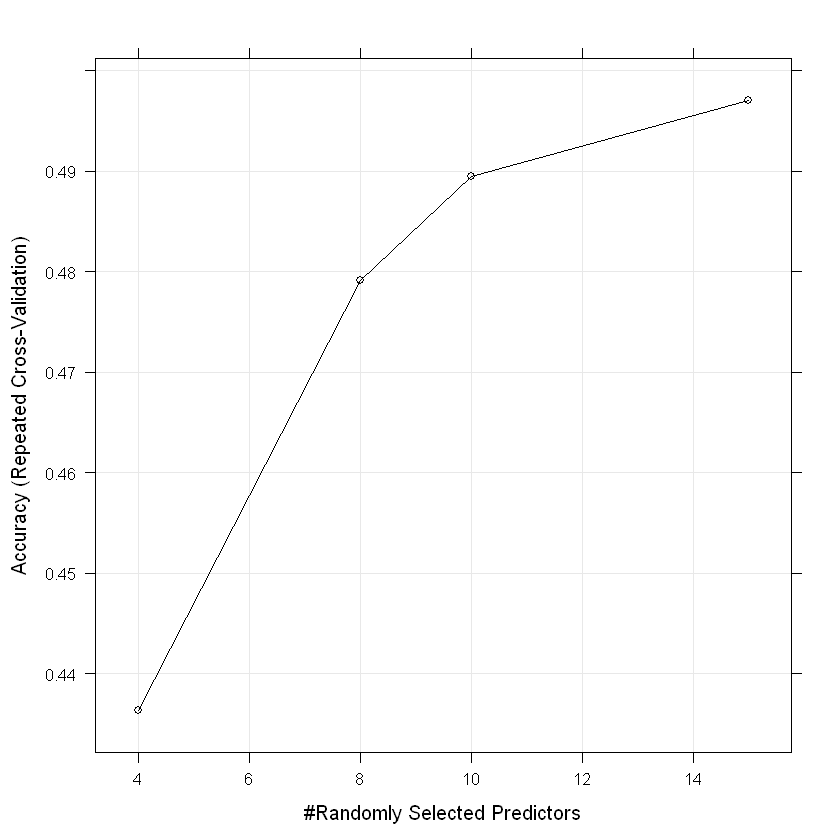

In [89]:
rf_fit
plot(rf_fit)

In [91]:
RandomForest_std=predict(rf_fit,newdata=test)

### Performanca Measure

In [92]:
perf_dt("First Data Set for Random Forest", as.numeric(RandomForest_std), as.numeric(test$y))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Random Forest,1164,2.651203,1.197011,-0.04957874,0.3932274,0.03814085,0.8101375,0.3055736


In [94]:
confusionMatrix(data = as.factor(RandomForest_std), reference = as.factor(test$y), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4   5
         1 244  12  36  21  25
         2   0  13   6   3   3
         3  53  67 252 146  56
         4  19  15  46  57  22
         5   8   3  15  18  24

Overall Statistics
                                         
               Accuracy : 0.5069         
                 95% CI : (0.4777, 0.536)
    No Information Rate : 0.305          
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.3258         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Precision              0.7219  0.52000   0.4390  0.35849  0.35294
Recall                 0.7531  0.11818   0.7099  0.23265  0.18462
F1                     0.7372  0.19259   0.5425  0.28218  0.24242
Prevalence             0.2784  0.09450   0.3050  0.21048  0.11168
Detection 

### Performanca Measure

In [95]:
perf_dt("First Data Set for Random Forest", as.numeric(RandomForest_std), as.numeric(test$y))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Random Forest,1164,2.651203,1.197011,-0.04957874,0.3932274,0.03814085,0.8101375,0.3055736


## Stochastic Gradient Boosting(SGB)

In [96]:
set.seed(35)

In [ ]:
gbmGrid=expand.grid(interaction.depth = c(1, 3, 5), 
                        n.trees = (1:5)*50, 
                        shrinkage = c(0.1, 0.3, 0.5),
                        n.minobsinnode = 20)
                                                                

gbm_fit=train(y ~ ., data = train, 
                 method = "gbm", 
                 trControl = fitControl,  
                 tuneGrid = gbmGrid,
                 verbose=F) #verbose is an argument from gbm, prints to screen

plot(gbm_fit)

In [ ]:
predicted_sgb=predict(gbm_fit,train)

### Performanca Measure

In [ ]:
confusionMatrix(data = as.factor(predicted_sgb), reference = as.factor(test$y), mode = "prec_recall")

In [ ]:
perf_dt("First Data Set for Random Forest", as.numeric(predicted_sgb), as.numeric(test$y))

# General Result for 4 Method for Pisa Reading Results

In [94]:
perf_dt("Pisa Data Set for Lasso Function with min lambda and mse objective", as.numeric(test$y), as.numeric(prediction_pra_mae_min))
perf_dt("Decision Tree with CV for Pisa Dataset",as.numeric(test$y),as.numeric(predicted_std))
perf_dt("First Data Set for Random Forest", as.numeric(test$y), as.numeric(RandomForest_std))
perf_dt("First Data Set for Stochastic Gradient Boosting", as.numeric(test$y), as.numeric(predicted_sgb))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with min lambda and mse objective,721,1.226075,0.4185786,0.8291855,0.8814147,0.0391556,1.016644,0.8291855


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Decision Tree with CV for Pisa Dataset,721,1.226075,0.4185786,0.005656109,0.0554785,0.01028599,0.07628294,0.06221719


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Random Forest,721,1.226075,0.4185786,0.005656109,0.02427184,0.006934813,0.03467406,0.02828054


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Stochastic Gradient Boosting,721,1.226075,0.4185786,0.003393665,0.02912621,0.007469022,0.04022191,0.03280543


## Performance

In [ ]:
results = resamples(list("Random Forest"=rf_fit,#"Linear Regression with Penalty"=lasso_model_spam_mae_min,
                         "Stochastic Gradient Boosting"=gbm_fit),metrics='Accuracy')
summary(results)
bwplot(results)
densityplot(results)

In [100]:
confusionMatrix(data = as.factor(prediction_pra_mae_spam_min), reference = as.factor(test_spam$X1), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 538  32
         1  20 131
                                          
               Accuracy : 0.9279          
                 95% CI : (0.9065, 0.9457)
    No Information Rate : 0.7739          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7884          
                                          
 Mcnemar's Test P-Value : 0.1272          
                                          
              Precision : 0.9439          
                 Recall : 0.9642          
                     F1 : 0.9539          
             Prevalence : 0.7739          
         Detection Rate : 0.7462          
   Detection Prevalence : 0.7906          
      Balanced Accuracy : 0.8839          
                                          
       'Positive' Class : 0               
                                          

In [101]:
confusionMatrix(data = as.factor(predicted_pisa), reference = as.factor(test_spam$X1), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 533  30
         1  25 133
                                         
               Accuracy : 0.9237         
                 95% CI : (0.9019, 0.942)
    No Information Rate : 0.7739         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.7796         
                                         
 Mcnemar's Test P-Value : 0.5896         
                                         
              Precision : 0.9467         
                 Recall : 0.9552         
                     F1 : 0.9509         
             Prevalence : 0.7739         
         Detection Rate : 0.7393         
   Detection Prevalence : 0.7809         
      Balanced Accuracy : 0.8856         
                                         
       'Positive' Class : 0              
                                         

In [102]:
confusionMatrix(data = as.factor(PredictRandomForest_spam), reference = as.factor(test_spam$X1), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 548  15
         1  10 148
                                          
               Accuracy : 0.9653          
                 95% CI : (0.9492, 0.9774)
    No Information Rate : 0.7739          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8998          
                                          
 Mcnemar's Test P-Value : 0.4237          
                                          
              Precision : 0.9734          
                 Recall : 0.9821          
                     F1 : 0.9777          
             Prevalence : 0.7739          
         Detection Rate : 0.7601          
   Detection Prevalence : 0.7809          
      Balanced Accuracy : 0.9450          
                                          
       'Positive' Class : 0               
                                          

In [103]:
confusionMatrix(data = as.factor(predicted_spam_sgb), reference = as.factor(test_spam$X1), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 545  16
         1  13 147
                                          
               Accuracy : 0.9598          
                 95% CI : (0.9427, 0.9729)
    No Information Rate : 0.7739          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8843          
                                          
 Mcnemar's Test P-Value : 0.7103          
                                          
              Precision : 0.9715          
                 Recall : 0.9767          
                     F1 : 0.9741          
             Prevalence : 0.7739          
         Detection Rate : 0.7559          
   Detection Prevalence : 0.7781          
      Balanced Accuracy : 0.9393          
                                          
       'Positive' Class : 0               
                                          